In [1]:
import os
import json
from keras.preprocessing.text import Tokenizer
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from nltk.tokenize import RegexpTokenizer
import gensim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from gensim import models
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models import Doc2Vec
from gensim.models import TfidfModel
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import WordNetLemmatizer

from pprint import pprint
from nltk.tag.stanford import StanfordNERTagger
from gensim.models import CoherenceModel
import time
import pymongo
import py2neo
from py2neo import Node, Relationship
from py2neo import Graph

/Users/shengyuan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shengyuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data(dir,round,args):
    data = []
    data_args = []
    for i in range(1,6):
        with open(os.path.join(dir,'r%d/%d.json'%(round,i)),'r') as d:
            tem_data = json.load(d)
        data.extend(tem_data['result']['docs'])
    for i in range(len(data)):
        data_args.append(data[i][args])
        data_args = list(set(data_args))
    return data_args

def getMyStopWordList(text,st,Type):
    myStops=[]
    ctext=re.sub("[^a-zA-Z]"," ", text)
    t=st.tag(ctext.split())
    for name in t:
        if(name[1]==Type):
            myStops.append(name[0].lower())
    return myStops
def review_to_wordlist(text, myStops,remove_stopwords=True):
             
       
    t = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)#remove http url
    t = re.sub(r'www.\S+','',t)#remove www url
    t = re.sub("[\\w.]*@[\\w.]+", "", t)# remove email and twitter account
    t = re.sub("\\S+.com\\S+",'',t) # remove .com url
    t = re.sub("\\S+.com",'',t) # remove .com url
    t = re.sub("\\S+.COM",'',t) # remove .com url
    t = re.sub("(Politics|Business|World|National|Sport|Entertainment|Lifestyle|Money|Environment|World Cup 2018) (Show|Hide) subsections", "", t)
    t = re.sub("Normal text sizeLarger text sizeVery large text size", "", t)
    t = re.sub("WAtoday", "", t)
    t = re.sub("The Sydney Morning Herald", "", t)
    t = re.sub("(Exclusive|Opinion) Normal text", "", t)
    t = re.sub("[^a-zA-Z]"," ", t)
    t = re.sub("\xa0", " ", t) #remove noise from parsing
    t = re.sub("\ufeff", " ", t) #remove noise from parsing
    
    # 3. Convert words to lower case and split them
    words = t.lower().split()
    #
    # 4. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        
        words = [w for w in words if not w in stops]
        words = [w for w in words if not w in myStops]
    stem_word=[]
    stemmer = WordNetLemmatizer() #PorterStemmer()
    
    for word in words:
      
       
        stem_word.append(stemmer.lemmatize(word))
        
    # 5. Return a list of words
    return stem_word


In [3]:
def KeySentence_with_weight(data, article_number, key_word_list,prob_list,n_words,top_n_sentence,myStops):
    article=data[article_number]
    i=0;
    j=0;
    sentenceEnders = re.compile('[\n]')
    sentenceList = []
    sentenceList = sentenceEnders.split(article)
    newList=[]
    resultList=[]
    LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
    #print(article)
    #print(sentenceList)
    all_clean_sentence=[]
    for s in sentenceList:           
  
        #Pre-processing
        processed_sentence = review_to_wordlist(s,myStops)
        
        
        # add tokens to list
        if processed_sentence:
            all_clean_sentence.append(LabeledSentence1(processed_sentence,[j]))
            j=j+1
            newList.append(sentenceList[i])
        i=i+1
    sentence_scores=np.zeros(j)
    d2v_model = Doc2Vec(all_clean_sentence, vector_size = 1000, min_count = 1, workers=7, dm = 1, 
                    alpha=0.025, min_alpha=0.001)
    d2v_model.train(all_clean_sentence, total_examples=d2v_model.corpus_count, epochs=100, start_alpha=0.002, end_alpha=-0.016)
    for n in range(0,n_words):
        tokens = key_word_list[1][n].split()
        prob=prob_list[1][n]
        new_vector = d2v_model.infer_vector(tokens)
        sims = d2v_model.docvecs.most_similar([new_vector],topn=j)
        
        for result in sims:
            if(result[0]<=j):
                sentence_scores[result[0]]=sentence_scores[result[0]]+prob*result[1]
        #print(all_clean_sentence)
        #print(sentenceList)
        
    
    index=np.argsort(sentence_scores)
    if j<top_n_sentence:
        top_n_sentence=j
    for i in range(0,top_n_sentence):
        resultList.append(newList[index[j-i-1]])
    return resultList


In [4]:
def getLDAPerfomance(corpus_tfidf, dictionary,all_content, n_topics,iterations,passes):
    LDA_model = ldamodel.LdaModel(corpus_tfidf, 
                              id2word=dictionary, 
                              num_topics=n_topics,
                              iterations=iterations,
                              random_state=np.random.seed(1),
                            
                              passes=passes,
                              alpha='auto',
                              eta='auto'
                              )
    # a measure of how good the model is. lower the better.
    perplexity=LDA_model.log_perplexity(corpus_tfidf)
    # a measure of how good the model is. higher the better.
    coherence_model_lda = CoherenceModel(model=LDA_model, texts=all_content, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    return perplexity,coherence_score

In [5]:
# load the data
dir='/Users/shengyuan/Desktop/Study/CAPSTONE/RoyalCommission' #data fold path
args = 'content'  #data type
round=4

data = load_data(dir,round,args)
# Number of corpus
l=len(data)

In [6]:
# Create Stop words
StartTime=time.time()
myStops=[]
st = StanfordNERTagger('/Users/shengyuan/desktop/study/Capstone/RoyalCommission/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                           '/Users/shengyuan/desktop/study/Capstone/RoyalCommission/stanford-ner-2018-02-27/stanford-ner.jar',
                            encoding='utf-8')
count=0
Organization_Name=[]
for text in data:  
    StopWordList=getMyStopWordList(text,st,'PERSON')
    OrganizationList=getMyStopWordList(text,st,'ORGANIZATION')
    for item in StopWordList:
        myStops.append(item)
    for item in OrganizationList:
        Organization_Name.append(item)  
    count=count+1
    print(count)

Organization_Name=set(Organization_Name)
for item in Organization_Name:
    if item in myStops:
        myStops.remove(item)

EndTime=time.time()
Manual_StopWords=['royal','commission','ms','mr','per','cent','commissions','c','m','orr','hearing','hear','show','said','u']
for item in Manual_StopWords:
    myStops.append(item)
myStops=set(myStops)   
print(myStops)
print(Organization_Name)
print("Running Time:",EndTime-StartTime,'s')





/Users/shengyuan/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
print(myStops)

{'klassen', 'sumer', 'spacey', 'devlin', 'lynton', 'dixon', 'dive', 'christopher', 'gray', 'tunny', 'bloxham', 'porter', 'graeme', 'bendigo', 'july', 'alethea', 'vassella', 'cliffordfinally', 'younger', 'zheng', 'pentland', 'baragwanath', 'bryn', 'tasa', 'surrey', 'richardson', 'aaron', 'invocare', 'chalmers', 'ezzy', 'clancy', 'swan', 'crossman', 'mungly', 'mackay', 'bligh', 'rohr', 'youi', 'petersen', 'redfern', 'loftfield', 'howden', 'lindsay', 'greg', 'dan', 'mike', 'hansard', 'macmillan', 'katy', 'michael', 'howitt', 'lydotes', 'clinton', 'anthony', 'pannek', 'leo', 'elvis', 'clifton', 'barnaby', 'trump', 'hamilton', 'fertig', 'vesna', 'marika', 'spier', 'eltham', 'jonathan', 'julie', 'power', 'trotter', 'angus', 'negyal', 'hans', 'streur', 'sheldon', 'rundle', 'loading', 'susan', 'thelma', 'dawson', 'ironfield', 'oughton', 'mckernan', 'telstra', 'don', 'graauw', 'emily', 'steinberg', 'elise', 'kevin', 'hirst', 'vale', 'schaefer', 'poxon', 'speakman', 'sokulsky', 'ghoshal', 'morle

In [8]:
all_content = []
#Pre-processing
for text in data:             
    
    processed_content = review_to_wordlist(text,myStops)
    
    # add tokens to list
    all_content.append(processed_content)

# Prepare LDA 
dictionary = Dictionary(all_content)
corpus = [dictionary.doc2bow(text) for text in all_content]

# TF-IDF
tfidf_model = TfidfModel(corpus)  # fit model
corpus_tfidf = tfidf_model[corpus]



    

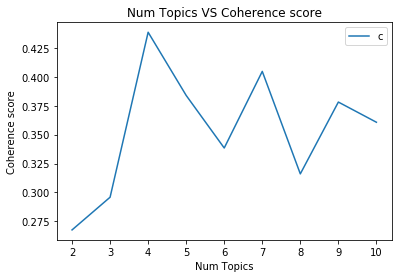

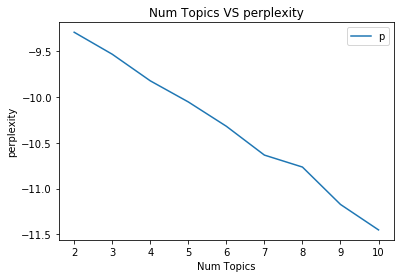

In [9]:
# Analysis of LDA model
# Number of Topic
perplexity_list=[]
coherence_score_list=[]
iteration=100
passes=3
topic_num_range=np.arange(2,11)
for n in topic_num_range:
    p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n,iteration,passes)
    perplexity_list.append(p)
    coherence_score_list.append(c)
    
plt.plot(topic_num_range, coherence_score_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics VS Coherence score')
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.plot(topic_num_range, perplexity_list)
plt.xlabel("Num Topics")
plt.ylabel("perplexity")
plt.title('Num Topics VS perplexity')
plt.legend(("perplexity"), loc='best')
plt.show()

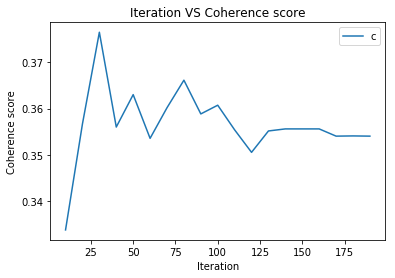

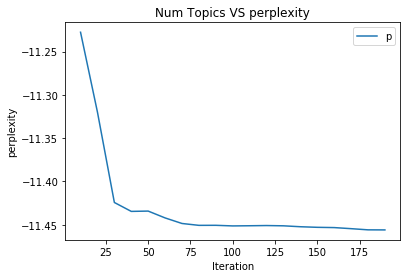

In [10]:
# Analysis of LDA model
# Number of iteration
perplexity_list=[]
coherence_score_list=[]
iteration_range=np.arange(10,200,10)
passes=3
n_topic=10
for iteration in iteration_range:
    p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n_topic,iteration,passes)
    perplexity_list.append(p)
    coherence_score_list.append(c)
    
plt.plot(iteration_range, coherence_score_list)
plt.xlabel("Iteration")
plt.ylabel("Coherence score")
plt.title('Iteration VS Coherence score')
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.plot(iteration_range, perplexity_list)
plt.xlabel("Iteration")
plt.ylabel("perplexity")
plt.title('Num Topics VS perplexity')
plt.legend(("perplexity"), loc='best')
plt.show()

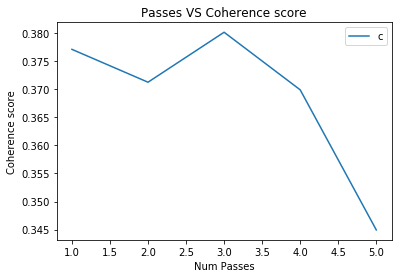

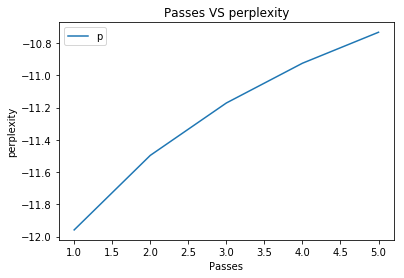

In [11]:
# Analysis of LDA model
# Number of Passes
perplexity_list=[]
coherence_score_list=[]
iteration=80

n_topic=9
passes_range=np.arange(1,6)
for passes in passes_range:
    p,c=getLDAPerfomance(corpus_tfidf, dictionary, all_content,n_topic,iteration,passes)
    perplexity_list.append(p)
    coherence_score_list.append(c)
    
plt.plot(passes_range, coherence_score_list)
plt.xlabel("Num Passes")
plt.ylabel("Coherence score")
plt.title('Passes VS Coherence score')
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.plot(passes_range, perplexity_list)
plt.xlabel("Passes")
plt.ylabel("perplexity")
plt.title('Passes VS perplexity')
plt.legend(("perplexity"), loc='best')
plt.show()

In [19]:
# Optimal Parameter
n_topics=7
n_words=9;
passes=3
iteration=50
LDA_model = ldamodel.LdaModel(corpus_tfidf, 
                              id2word=dictionary, 
                              num_topics=n_topics,
                              iterations=80,
                              random_state=np.random.seed(1),# setting random seed to get the same results each time.
                              
                              passes=passes,
                              alpha='auto',
                              eta='auto'
                             )
LDA_model.show_topics()



[(0,
  '0.001*"cba" + 0.001*"bank" + 0.001*"growth" + 0.001*"rate" + 0.001*"aboriginal" + 0.001*"property" + 0.001*"mortgage" + 0.001*"business" + 0.001*"investor" + 0.001*"lender"'),
 (1,
  '0.001*"amp" + 0.001*"hsf" + 0.000*"farmer" + 0.000*"asic" + 0.000*"bank" + 0.000*"rate" + 0.000*"cba" + 0.000*"insurance" + 0.000*"superannuation" + 0.000*"growth"'),
 (2,
  '0.001*"broker" + 0.001*"growth" + 0.001*"debt" + 0.001*"bank" + 0.001*"farm" + 0.001*"u" + 0.001*"price" + 0.001*"housing" + 0.001*"credit" + 0.001*"mortgage"'),
 (3,
  '0.001*"asic" + 0.001*"funeral" + 0.001*"acbf" + 0.001*"fee" + 0.001*"informal" + 0.001*"client" + 0.001*"aboriginal" + 0.001*"overdraft" + 0.001*"insure" + 0.001*"consumer"'),
 (4,
  '0.002*"funeral" + 0.001*"insurance" + 0.001*"aboriginal" + 0.001*"cba" + 0.001*"bank" + 0.001*"landmark" + 0.001*"customer" + 0.001*"advice" + 0.001*"policy" + 0.001*"property"'),
 (5,
  '0.001*"property" + 0.001*"rural" + 0.001*"cattle" + 0.001*"bank" + 0.001*"rate" + 0.001*"lo

In [20]:
# Visulization
lda_vis = pyLDAvis.gensim.prepare(LDA_model, corpus_tfidf, dictionary)
pyLDAvis.display(lda_vis)

In [21]:
# Finding the topic word list and their coreponding probablity
x=LDA_model.show_topics(num_topics=n_topics, num_words=n_words,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
topics_words_probability=[(tp[0], [wd[1] for wd in tp[1]]) for tp in x]

all_topics = LDA_model.get_document_topics(corpus_tfidf, per_word_topics=True)
count=1;
content_list=[]
content_num=[]
topic_list=[]
prob_list=[]
tp_words=[]
for doc_topics, word_topics, phi_values in all_topics:
    print('Document ',count,'\n')
    print('Document topics:', doc_topics)
    
    for doc_prob in doc_topics:
        topic_list.append(doc_prob[0])
        prob_list.append(doc_prob[1])
        words=" ".join(topics_words[doc_prob[0]][1])
        tp_words.append(words)
        
        content_list.append(data[count-1])
        content_num.append(count-1);
    #print ('Word topics:', word_topics)
    #print ('Phi values:', phi_values)
    print(" ")
    print('-------------- \n')
    count=count+1

Document  1 

Document topics: [(0, 0.01013196), (2, 0.010835539), (4, 0.9423306), (5, 0.010622467)]
 
-------------- 

Document  2 

Document topics: [(4, 0.9689792)]
 
-------------- 

Document  3 

Document topics: [(2, 0.96333444)]
 
-------------- 

Document  4 

Document topics: [(4, 0.9535168)]
 
-------------- 

Document  5 

Document topics: [(2, 0.010557919), (4, 0.9438095), (5, 0.010350256)]
 
-------------- 

Document  6 

Document topics: [(5, 0.96265274)]
 
-------------- 

Document  7 

Document topics: [(0, 0.011123943), (2, 0.011895933), (4, 0.5482947), (5, 0.011662701), (6, 0.39933598)]
 
-------------- 

Document  8 

Document topics: [(4, 0.959673)]
 
-------------- 

Document  9 

Document topics: [(0, 0.016692543), (1, 0.013195998), (2, 0.01785332), (3, 0.013344025), (4, 0.90498716), (5, 0.017500332), (6, 0.016426643)]
 
-------------- 

Document  10 

Document topics: [(2, 0.2282878), (4, 0.62958443), (6, 0.13135253)]
 
-------------- 

Document  11 

Document to

Document  111 

Document topics: [(4, 0.9642145)]
 
-------------- 

Document  112 

Document topics: [(4, 0.96912503)]
 
-------------- 

Document  113 

Document topics: [(0, 0.011042247), (2, 0.011809261), (4, 0.6186248), (5, 0.33010063), (6, 0.010866108)]
 
-------------- 

Document  114 

Document topics: [(0, 0.4512379), (4, 0.52885765)]
 
-------------- 

Document  115 

Document topics: [(0, 0.011387475), (2, 0.01217804), (4, 0.93518364), (5, 0.011939253), (6, 0.011205759)]
 
-------------- 

Document  116 

Document topics: [(0, 0.9130394), (1, 0.011186045), (2, 0.015131545), (3, 0.011311504), (4, 0.020572785), (5, 0.014834727), (6, 0.013923977)]
 
-------------- 

Document  117 

Document topics: [(0, 0.56399995), (4, 0.4053168)]
 
-------------- 

Document  118 

Document topics: [(2, 0.010593948), (4, 0.9436129), (5, 0.010386722)]
 
-------------- 

Document  119 

Document topics: [(0, 0.93447834), (2, 0.011401175), (4, 0.015500085), (5, 0.011177696), (6, 0.010491272)]
 
-

Document  215 

Document topics: [(4, 0.95706165)]
 
-------------- 

Document  216 

Document topics: [(2, 0.43605936), (4, 0.5424282)]
 
-------------- 

Document  217 

Document topics: [(4, 0.95172495)]
 
-------------- 

Document  218 

Document topics: [(0, 0.013852753), (1, 0.010951213), (2, 0.0148146665), (3, 0.5451439), (4, 0.38708192), (5, 0.014523806), (6, 0.013631731)]
 
-------------- 

Document  219 

Document topics: [(0, 0.8909983), (1, 0.014015751), (2, 0.01896041), (3, 0.014172939), (4, 0.025818503), (5, 0.01858796), (6, 0.017446153)]
 
-------------- 

Document  220 

Document topics: [(4, 0.9633069)]
 
-------------- 

Document  221 

Document topics: [(2, 0.946209), (4, 0.012877772)]
 
-------------- 

Document  222 

Document topics: [(0, 0.8718014), (1, 0.016484732), (2, 0.022300716), (3, 0.016669631), (4, 0.030362256), (5, 0.021861805), (6, 0.020519452)]
 
-------------- 

Document  223 

Document topics: [(4, 0.95738894)]
 
-------------- 

Document  224 

Docu

Document topics: [(0, 0.94823986), (4, 0.012250979)]
 
-------------- 

Document  320 

Document topics: [(0, 0.36892635), (4, 0.5953387)]
 
-------------- 

Document  321 

Document topics: [(2, 0.45967817), (4, 0.4998809)]
 
-------------- 

Document  322 

Document topics: [(0, 0.02725899), (1, 0.021550087), (2, 0.029150382), (3, 0.02179179), (4, 0.039581355), (5, 0.83384347), (6, 0.026823957)]
 
-------------- 

Document  323 

Document topics: [(4, 0.9469139)]
 
-------------- 

Document  324 

Document topics: [(4, 0.28999096), (5, 0.6808443)]
 
-------------- 

Document  325 

Document topics: [(4, 0.80775607), (6, 0.14844954)]
 
-------------- 

Document  326 

Document topics: [(0, 0.027775344), (1, 0.021958081), (2, 0.029702874), (3, 0.8237121), (4, 0.040398758), (5, 0.029120103), (6, 0.027332721)]
 
-------------- 

Document  327 

Document topics: [(4, 0.30983672), (6, 0.65097517)]
 
-------------- 

Document  328 

Document topics: [(2, 0.95143706), (4, 0.011621904)]
 
---

Document  407 

Document topics: [(4, 0.9504285)]
 
-------------- 

Document  408 

Document topics: [(4, 0.48530874), (5, 0.47668785)]
 
-------------- 

Document  409 

Document topics: [(4, 0.49376073), (6, 0.4661064)]
 
-------------- 

Document  410 

Document topics: [(4, 0.66927695), (6, 0.29963636)]
 
-------------- 

Document  411 

Document topics: [(4, 0.26922768), (5, 0.7039292)]
 
-------------- 

Document  412 

Document topics: [(4, 0.94886804)]
 
-------------- 

Document  413 

Document topics: [(4, 0.30668804), (5, 0.6574878)]
 
-------------- 

Document  414 

Document topics: [(4, 0.9601066)]
 
-------------- 

Document  415 

Document topics: [(0, 0.5940528), (4, 0.36483136)]
 
-------------- 

Document  416 

Document topics: [(4, 0.9680777)]
 
-------------- 

Document  417 

Document topics: [(0, 0.018780146), (1, 0.01484708), (2, 0.020083886), (3, 0.015013607), (4, 0.8931051), (5, 0.01968947), (6, 0.018480757)]
 
-------------- 

Document  418 

Document topic

Document  499 

Document topics: [(4, 0.9632659)]
 
-------------- 

Document  500 

Document topics: [(0, 0.010014439), (2, 0.9391242), (4, 0.014584833), (5, 0.0104992455)]
 
-------------- 

Document  501 

Document topics: [(2, 0.8046449), (4, 0.17885774)]
 
-------------- 

Document  502 

Document topics: [(0, 0.010035739), (2, 0.010732049), (4, 0.94287795), (5, 0.0105217025)]
 
-------------- 

Document  503 

Document topics: [(0, 0.011217551), (2, 0.011995832), (4, 0.93615097), (5, 0.011761619), (6, 0.011038534)]
 
-------------- 

Document  504 

Document topics: [(0, 0.30159128), (4, 0.66054827)]
 
-------------- 

Document  505 

Document topics: [(0, 0.023975678), (1, 0.018953938), (2, 0.025640508), (3, 0.019166544), (4, 0.03489614), (5, 0.853774), (6, 0.023593167)]
 
-------------- 

Document  506 

Document topics: [(2, 0.43689418), (4, 0.012704691), (5, 0.5192079)]
 
-------------- 

Document  507 

Document topics: [(2, 0.9580414), (4, 0.010045304)]
 
-------------- 

D

Document  586 

Document topics: [(4, 0.96565753)]
 
-------------- 

Document  587 

Document topics: [(4, 0.010322971), (6, 0.95627445)]
 
-------------- 

Document  588 

Document topics: [(0, 0.012519115), (2, 0.9238939), (3, 0.010007911), (4, 0.018237205), (5, 0.01312551), (6, 0.012319419)]
 
-------------- 

Document  589 

Document topics: [(4, 0.95640105)]
 
-------------- 

Document  590 

Document topics: [(0, 0.015870495), (1, 0.012546568), (2, 0.9035532), (3, 0.012687294), (4, 0.023085803), (5, 0.016639233), (6, 0.015617475)]
 
-------------- 

Document  591 

Document topics: [(0, 0.010134564), (1, 0.23962916), (2, 0.010838441), (4, 0.71069777), (5, 0.010625576)]
 
-------------- 

Document  592 

Document topics: [(3, 0.4440809), (4, 0.530266)]
 
-------------- 

Document  593 

Document topics: [(2, 0.39171764), (4, 0.5724379)]
 
-------------- 

Document  594 

Document topics: [(4, 0.52979267), (5, 0.43402216)]
 
-------------- 

Document  595 

Document topics: [(2, 0

In [22]:
# Create the table to display the sorted result
df2 = pd.DataFrame(topic_list,columns=['Topic'])
df3 = pd.DataFrame(content_list,columns=['Content'])
df4 =pd.DataFrame(tp_words,columns=['Topic Words'])
df5 =pd.DataFrame(content_num,columns=['Article Number'])
df1=pd.DataFrame(prob_list,columns=['Probability'])

df1 = df1.assign(df2=df2.values)
df1 = df1.assign(df3=df3.values)
df1=df1.assign(df4=df4.values)
myTable = df1.assign(df5=df5.values)
myTable.columns=['Probability','Topic','Cotent','Topic Words','Article Number']
sortedTable=myTable.sort_values(by=['Topic', 'Probability'],ascending=[True,False])
sortedTable

,Probability,Topic,Cotent,Topic Words,Article Number
1357,0.968132,0,Brand: Mars Bar Australia \nAgency: Clemenger ...,cba bank growth rate aboriginal property mortg...,485
952,0.967726,0,We suffer in an emotionally abusive relationsh...,cba bank growth rate aboriginal property mortg...,346
874,0.966551,0,SHARE CLOSE: Market turns around as investors ...,cba bank growth rate aboriginal property mortg...,312
1437,0.964190,0,SHARE OPEN First day of the new Financial Year...,cba bank growth rate aboriginal property mortg...,512
801,0.962898,0,"About our council… \nFIRSTLY, I am totally sup...",cba bank growth rate aboriginal property mortg...,288
110,0.961927,0,The Australian sharemarket is on track to fini...,cba bank growth rate aboriginal property mortg...,37
1507,0.960015,0,The Australian sharemarket is on track to fini...,cba bank growth rate aboriginal property mortg...,538
916,0.959937,0,The right to know never more relevant\n\nWith ...,cba bank growth rate aboriginal property mortg...,330
789,0.959451,0,Five years after Commonwealth Bank whistleblow...,cba bank growth rate aboriginal property mortg...,283
429,0.956744,0,Share close: Market in retreat with banks down...,cba bank growth rate aboriginal property mortg...,160


In [23]:
# Retrieve key sentences
#Parameter
top_n_sentence=2
top_n_article=2

graph = Graph(password="123")
Hearing_node=Node("Hearings",Round=round)
graph.create(Hearing_node)

MyResult={}
MyResult['Round'+str(round)]={}

for i in range(0,n_topics):
    df=sortedTable.loc[sortedTable['Topic'] == i]
    df.reset_index()
    

    Topic_index="Topic"+str(i+1)
    print(Topic_index,":\n")
    
    key_words=df.iloc[0,-2]
    Topic_node=Node("Topic",Round=round,Topic_ID=int(i+1),Key_Words=key_words)
    
    Relation_Shows=Relationship(Hearing_node,'Shows',Topic_node)
    graph.create(Topic_node)
    graph.create(Relation_Shows)
    
    for j in range(0,top_n_article):
        article_number=df.iloc[j,-1]
        key_words=df.iloc[j,-2]
        key_word_list=topics_words[i] 
        prob_list=topics_words_probability[i] 
        a2=KeySentence_with_weight(data,article_number, key_word_list,prob_list,n_words,top_n_sentence,myStops)
        
        Article_node=Node("Article",Article_ID= int(article_number),Round=round,Topic_ID=int(i+1))
        
        
        Relation_Retrieves=Relationship(Topic_node,'Retrieves',Article_node)
        graph.create(Article_node)
        graph.create(Relation_Retrieves)
        
        for item in a2:
            Key_Sentence_node=Node("Key_Sentences",Key_Sentence=item)
            Relation_Provides=Relationship(Article_node,'Provides',Key_Sentence_node)
            graph.create(Key_Sentence_node)
            graph.create(Relation_Provides)
        
        MyResult['Round'+str(round)][Topic_index]={}   
        MyResult['Round'+str(round)][Topic_index]['Key Words']=key_words
        MyResult['Round'+str(round)][Topic_index]['Article'+str(article_number)]={}
        MyResult['Round'+str(round)][Topic_index]['Article'+str(article_number)]['Key Setences']=a2
      

        print("Key Words:","\n",key_words,"\n")
        print("Article Number:","\n",article_number)
        print("Key Sentences:","\n",a2,"\n")
        print("-------------------------------------------------------------------------------------------------------\n")



Topic1 :



/Users/shengyuan/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Key Words: 
 cba bank growth rate aboriginal property mortgage business investor 

Article Number: 
 485
Key Sentences: 
 ['“Whilst the strategic approach is not fresh, it’s very relevant in this campaign to help drum up the emotional aspect of being a pro sportsman, by tapping into the importance of “support” especially during the World Cup. ', '“Let’s face it: you don’t think about how much energy a Mars Bar delivers when you’re halfway through its delicious chewy, caramel goodness. All I ever think of is why I only bought the regular size and not the supersize option. I’m glad they dropped the previous strategy and positioning and moved on to a much more believable product truth. It’s chocolate – indulgent, full of sugar and a load of numbers no one dares look up for obvious reasons, and if that solves or helps me get through a part of my day then I’m buying it, isn’t that why we call it a snack? Just sit back, enjoy and get on with it… chocolate doesn’t need to be much more complic

Key Words: 
 funeral insurance aboriginal cba bank landmark customer advice policy 

Article Number: 
 141
Key Sentences: 
 ['Macquarie and its bankers have a reputation for being aggressive. But while this "whatever-it-takes" attitude might be needed to get a big takeover deal over the line, it had begun to permeate other arms of the company, taking hold at the broker and adviser level too.', 'Personal dealing, personal investment, conflicts of interest and markets conduct policies were also located updated and revised. Same went for confidentiality, information barrier and Chinese walls policies.'] 

-------------------------------------------------------------------------------------------------------

Topic6 :

Key Words: 
 property rural cattle bank rate loan manager farmer overdraft 

Article Number: 
 206
Key Sentences: 
 ['Sign up', 'BRISBANE MOSQUE ATTACKS Right-wing extremists are suspected of targeting two mosques across Brisbane in acts of intimidation against a handful of 

In [17]:
pprint(MyResult)

{'Round4': {'Topic1': {'Article85': {'Key Setences': ['In his book, Bean '
                                                      'Counters - The Triumph '
                                                      'of the Accountants and '
                                                      'How they Broke '
                                                      'Capitalism, Brooks '
                                                      'makes the case '
                                                      'PricewaterhouseCoopers '
                                                      '(PwC), KPMG, Deloitte '
                                                      'and Ernst & Young (EY) '
                                                      'have massive conflicts '
                                                      'of interest because '
                                                      'they sell consultancy '
                                                      'services to the

In [18]:
graph.run('Match (n) detach delete n')